<a href="https://colab.research.google.com/github/Giraud-Pierre/Toxic_Comment_classification/blob/main/Classification_commentaires_toxiques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Classification de commentaires toxiques <h1>

# Sommaire :

1. [Importation des packages](#scrollTo=_lyJzHuKRNWX&line=1&uniqifier=1)
2. [Importation des données](#scrollTo=xZLpUMItRWc0)
3. [Etude des jeux de données](#scrollTo=-kUWzBzISpsK)
  1. [Etude des données d'entraînement](#scrollTo=tvhdEUGe3tpY)
  2. [Etude des données de test](#scrollTo=t7NZiVLY39ak)
4. [Préparation des données](#scrollTo=YIzpSrAjSsAM)
  1. [Définition de la fonction prepare_string(tweet) pour nettoyer les commentaires](#scrollTo=myHN502fX3-D)
  2. [nettoyage des commentaires](#scrollTo=-wCWxMIaYUC_)
  3. [Chargement des données une fois traitées](#scrollTo=zjoBmwkfZ2Qe)
  4. [Création de l'échantillon pour le Random Forest](#scrollTo=IMv-1_FuQ2WT)
  5. [Création du Bag of word pour le LSTM](#scrollTo=XmHPkfTASKO9)
  6. [Création du Bag of word des 20 000 mots les plus utilisés](#scrollTo=FXINU2NwSrEQ)
  7. [Création de la matrice des poids de classes](#scrollTo=cOpvm1ajS1PS)
  8. [Création de la matrice d'embedding GloVe](#scrollTo=2_NX8MWKTx2J)
5. [Etude de différents Modèles](#scrollTo=uK-m8hpGag8M)
  1. [RandomForest](#scrollTo=TF8KnMkciY01)
  2. [LSTM](#scrollTo=UbeCaDnn5qkK)
  3. [LSTM avec taille de bag of words = 20 000 et class_weigths](#scrollTo=VJ8LKUzV2RKU)
  4. [LSTM with GloVe](#scrollTo=D-gr9314F_ZP)
  5. [LSTM with dropout](#scrollTo=ZdzSYCSf_ICO)
  6. [Bidirectional LSTM](#scrollTo=6WWIQ73W_WD9)
6. [Pipeline](#scrollTo=LxNIQgESTCmE)

# **1. Importation des packages**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from time import time
import numpy as np
import pandas as pd
import random
import seaborn as sns

# Import Regex to clean up tweets
import re


# TF IDF Imports
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split  
from scipy.sparse import csc_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from joblib import dump, load

# RNN & LSTM Imports

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
!pip install tensorflow-addons
from tensorflow_addons.metrics import F1Score

# Visuals
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

# Pipeline
from sklearn.metrics import f1_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.5 MB/s eta 0:00:00


# **2. Importation des données**

Veuillez créer un raccourci du dossier ci-dessous dans un dossier ‘NLP_4A’ dans votre drive:
https://drive.google.com/drive/folders/1W5GG4tJkbGfFiyt8-k9VFJXM99Zaoeuc?usp=sharing

In [ ]:
training_data = pd.read_csv('/content/drive/MyDrive/NLP_4A/Projet/data_classification_commentaires_toxiques/train.csv')
test_comment = pd.read_csv('/content/drive/MyDrive/NLP_4A/Projet/data_classification_commentaires_toxiques/test.csv')
test_label = pd.read_csv('/content/drive/MyDrive/NLP_4A/Projet/data_classification_commentaires_toxiques/test_labels.csv')
training_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


On supprime la colonne id qui est inutile dans cette situation et on récupère les noms des différentes classes.

In [ ]:
training_data = training_data.drop(['id'], axis = 1)
test_data = test_comment.drop(['id'], axis = 1)
test_label = test_label.drop(['id'], axis = 1)

In [ ]:
labels = training_data.drop(['comment_text'],axis = 1).columns
labels

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [ ]:
for label in labels:
  test_data = test_data.join(test_label[label])

Certaine données du test ont été exclue par l'étude et sont signalé par la valeur -1 dans tous leur libellés. On va donc les retirer des données test.

In [ ]:
test_data = pd.DataFrame(test_data[test_data[labels[0]]!=-1])
test_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,Thank you for understanding. I think very high...,0,0,0,0,0,0
7,:Dear god this site is horrible.,0,0,0,0,0,0
11,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
13,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
14,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


# **3. Etude des jeux de données**

## 3.1. Etude des données d'entraînement

On calcule le nombre de commentaires dans chaque catégorie et leur proportion dans le nombre de commentaires totaux

In [ ]:
training_comments_repartition = {'total' : len(training_data)}
for label in labels:
  training_comments_repartition[label] = len(training_data[training_data[label] == 1])
training_comments_repartition

{'total': 159571,
 'toxic': 15294,
 'severe_toxic': 1595,
 'obscene': 8449,
 'threat': 478,
 'insult': 7877,
 'identity_hate': 1405}

In [ ]:
training_comments_proportion = {}
for label in labels:
  training_comments_proportion[label] = str(round(training_comments_repartition[label]*100 / training_comments_repartition['total'],2)) + "% des commentaires totaux"
training_comments_proportion

{'toxic': '9.58% des commentaires totaux',
 'severe_toxic': '1.0% des commentaires totaux',
 'obscene': '5.29% des commentaires totaux',
 'threat': '0.3% des commentaires totaux',
 'insult': '4.94% des commentaires totaux',
 'identity_hate': '0.88% des commentaires totaux'}

On calcule le nombre de commentaires en commun entre 2 classes et leur proportion dans le nombre de commentaires d'une de ces 2 classes

In [ ]:
two_classes_training_comments_repartition={}
for label1 in labels:
  two_classes_training_comments_repartition[label1] =  ""   #Pour améliorer la lisibilité, on ajoute une ligne indiquant la catégorie dans laquelle on se trouve
  for label2 in labels:
    if(label1 != label2):
      two_classes_training_comments_repartition[label1 + " and " + label2] = len(training_data[(training_data[label1] == 1) & (training_data[label2] == 1)])
two_classes_training_comments_repartition

{'toxic': '',
 'toxic and severe_toxic': 1595,
 'toxic and obscene': 7926,
 'toxic and threat': 449,
 'toxic and insult': 7344,
 'toxic and identity_hate': 1302,
 'severe_toxic': '',
 'severe_toxic and toxic': 1595,
 'severe_toxic and obscene': 1517,
 'severe_toxic and threat': 112,
 'severe_toxic and insult': 1371,
 'severe_toxic and identity_hate': 313,
 'obscene': '',
 'obscene and toxic': 7926,
 'obscene and severe_toxic': 1517,
 'obscene and threat': 301,
 'obscene and insult': 6155,
 'obscene and identity_hate': 1032,
 'threat': '',
 'threat and toxic': 449,
 'threat and severe_toxic': 112,
 'threat and obscene': 301,
 'threat and insult': 307,
 'threat and identity_hate': 98,
 'insult': '',
 'insult and toxic': 7344,
 'insult and severe_toxic': 1371,
 'insult and obscene': 6155,
 'insult and threat': 307,
 'insult and identity_hate': 1160,
 'identity_hate': '',
 'identity_hate and toxic': 1302,
 'identity_hate and severe_toxic': 313,
 'identity_hate and obscene': 1032,
 'identit

Voici une autre représentation un peu plus visuelle pour le dictionnaire précédent.

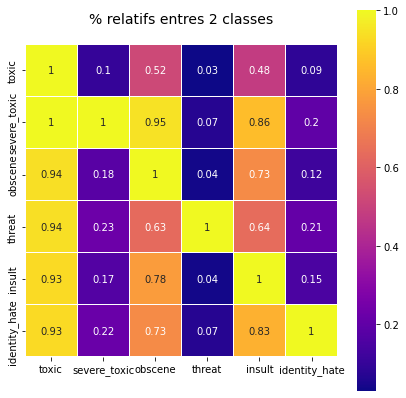

In [ ]:
heatmapTrain = pd.DataFrame(columns=labels, index=labels)

for labelY in labels:
  tmp = {}
  for labelX in labels:
    if(labelX != labelY):
      tmp[labelX] = round(two_classes_training_comments_repartition[labelY + " and " + labelX] / training_comments_repartition[labelY],2)
    else:
      tmp[labelX] = 1.
  heatmapTrain.loc[labelY] = pd.Series(tmp)

colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('% relatifs entres 2 classes',y=1.05,size=14)
sns.heatmap(heatmapTrain.astype(float),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,linecolor='white',annot=True)

## 3.2. Etude des données de test

On calcule le nombre de commentaires dans chaque catégorie et leur proportion dans le nombre de commentaires totaux

In [ ]:
test_comments_repartition = {'total' : len(test_data)}
for label in labels:
  test_comments_repartition[label] = len(test_data[test_data[label] == 1])
test_comments_repartition

{'total': 63978,
 'toxic': 6090,
 'severe_toxic': 367,
 'obscene': 3691,
 'threat': 211,
 'insult': 3427,
 'identity_hate': 712}

In [ ]:
test_comments_proportion = {}
for label in labels:
  test_comments_proportion[label] = str(round(test_comments_repartition[label]*100 / test_comments_repartition['total'],2)) + "% des commentaires totaux"
test_comments_proportion

{'toxic': '9.52% des commentaires totaux',
 'severe_toxic': '0.57% des commentaires totaux',
 'obscene': '5.77% des commentaires totaux',
 'threat': '0.33% des commentaires totaux',
 'insult': '5.36% des commentaires totaux',
 'identity_hate': '1.11% des commentaires totaux'}

On calcule le nombre de commentaires en commun entre 2 classes et leur proportion dans le nombre de commentaires d'une de ces 2 classes

In [ ]:
two_classes_test_comments_repartition={}
for label1 in labels:
  two_classes_test_comments_repartition[label1] =  ""   #Pour améliorer la lisibilité, on ajoute une ligne indiquant la catégorie dans laquelle on se trouve
  for label2 in labels:
    if(label1 != label2):
      two_classes_test_comments_repartition[label1 + " and " + label2] = len(test_data[(test_data[label1] == 1) & (test_data[label2] == 1)])
two_classes_test_comments_repartition

{'toxic': '',
 'toxic and severe_toxic': 367,
 'toxic and obscene': 3626,
 'toxic and threat': 205,
 'toxic and insult': 3342,
 'toxic and identity_hate': 693,
 'severe_toxic': '',
 'severe_toxic and toxic': 367,
 'severe_toxic and obscene': 363,
 'severe_toxic and threat': 46,
 'severe_toxic and insult': 330,
 'severe_toxic and identity_hate': 135,
 'obscene': '',
 'obscene and toxic': 3626,
 'obscene and severe_toxic': 363,
 'obscene and threat': 138,
 'obscene and insult': 2729,
 'obscene and identity_hate': 538,
 'threat': '',
 'threat and toxic': 205,
 'threat and severe_toxic': 46,
 'threat and obscene': 138,
 'threat and insult': 138,
 'threat and identity_hate': 47,
 'insult': '',
 'insult and toxic': 3342,
 'insult and severe_toxic': 330,
 'insult and obscene': 2729,
 'insult and threat': 138,
 'insult and identity_hate': 602,
 'identity_hate': '',
 'identity_hate and toxic': 693,
 'identity_hate and severe_toxic': 135,
 'identity_hate and obscene': 538,
 'identity_hate and th

Voici une autre représentation un peu plus visuelle pour le dictionnaire précédent.

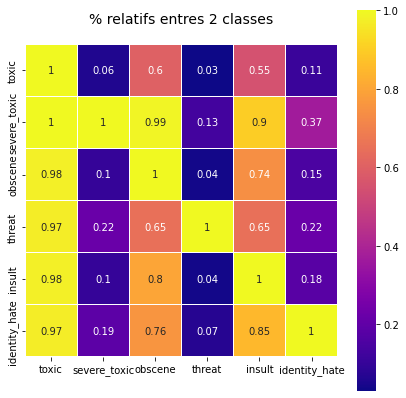

In [ ]:
heatmapTest = pd.DataFrame(columns=labels, index=labels)

for labelY in labels:
  tmp = {}
  for labelX in labels:
    if(labelX != labelY):
      tmp[labelX] = round(two_classes_test_comments_repartition[labelY + " and " + labelX] / test_comments_repartition[labelY],2)
    else:
      tmp[labelX] = 1.
  heatmapTest.loc[labelY] = pd.Series(tmp)

colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('% relatifs entres 2 classes',y=1.05,size=14)
sns.heatmap(heatmapTest.astype(float),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,linecolor='white',annot=True)

# **4. Préparation des données**

On va modifier les données pour enlever les abbréviations, les signes de ponctuations, les contractions de mots (fréquentes en anglais) pour faciliter le travail du réseau de neurone.
Ensuite on va créer les différentes matrices nècessaires aux modèles à partir de ces données (bag of words, matrice d'embedding, matrices de poids, ...)

## 4.1. Définition de la fonction prepare_string(tweet) pour nettoyer les commentaires

On crée une fonction qui va remplacer les contractions par leur formes complètes et abbréviations par leur significations

In [ ]:
tokenizer = TweetTokenizer(strip_handles=True)
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
corpus = []

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def clean(tweet): 
            
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)  
    
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"yrs", "years", tweet)
    tweet = re.sub(r"hrs", "hours", tweet)
    tweet = re.sub(r"2morow|2moro", "tomorrow", tweet)
    tweet = re.sub(r"2day", "today", tweet)
    tweet = re.sub(r"4got|4gotten", "forget", tweet)
    tweet = re.sub(r"b-day|bday", "b-day", tweet)
    tweet = re.sub(r"mother's", "mother", tweet)
    tweet = re.sub(r"mom's", "mom", tweet)
    tweet = re.sub(r"dad's", "dad", tweet)
    tweet = re.sub(r"hahah|hahaha|hahahaha", "haha", tweet)
    tweet = re.sub(r"lmao|lolz|rofl", "lol", tweet)
    tweet = re.sub(r"thanx|thnx", "thanks", tweet)
    tweet = re.sub(r"goood", "good", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    # Urls
    tweet = re.sub(r"http\S+", "", tweet)
    # Numbers
    tweet = re.sub(r'[0-9]', '', tweet)
    # Eliminating the mentions
    tweet = re.sub("(@[A-Za-z0-9_]+)","", tweet)
    # Remove punctuation and special chars (keep '!')
    for p in string.punctuation.replace('!', ''):
        tweet = tweet.replace(p, '')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')
        
    # Tokenize
    tweet_words = tokenizer.tokenize(tweet)
    
    # Eliminating the word if its length is less than 3
    tweet = [w for w in tweet_words if len(w)>2]
    
    # remove stopwords
    tweet = [w.lower() for w in tweet if not w in stop_words]  
    
    corpus.append(tweet)
    
    # join back
    tweet = ' '.join(tweet)
        
        
    return tweet

In [ ]:
variable_name = ""
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev_in_text(tweet):
    t=[]
    words=tweet.split()
    t = [abbreviations[w.lower()] if w.lower() in abbreviations.keys() else w for w in words]
    return ' '.join(t) 

In [ ]:
def prepare_string(tweet):
  tweet = clean(tweet)
  tweet = convert_abbrev_in_text(tweet)
  return tweet

## 4.2. nettoyage des commentaires

On utilise la fonction prepare_strings pour enlever les contractions et les abbréviations et on enlève les commentaires vides

In [ ]:
%%time
# Apply prepare_string to all rows in 'tweets' column
training_data['comment_text'] = training_data['comment_text'].apply(lambda s : prepare_string(s))
test_data['comment_text'] = test_data['comment_text'].apply(lambda s : prepare_string(s))

# Drop empty values from dataframe
training_data['comment_text'].replace('', np.nan, inplace=True)
training_data.dropna(subset=['comment_text'], inplace=True)

test_data['comment_text'].replace('', np.nan, inplace=True)
test_data.dropna(subset=['comment_text'], inplace=True)

CPU times: user 3min 6s, sys: 1.36 s, total: 3min 7s
Wall time: 3min 42s


L'opération précédente prenant un certain temps (quelques minutes), on sauvegarde les résultates précédents afin de pouvoir les recharger lors d'une session ultérieur sans refaire les étapes précédantes

In [ ]:
training_data.to_csv('/content/drive/MyDrive/NLP_4A/Projet/cleaned_data.csv', index=False)
test_data.to_csv('/content/drive/MyDrive/NLP_4A/Projet/cleaned_test.csv', index=False)

## 4.3. Chargement des données une fois traitées

Une fois les étapes précédentes réalisé une fois, on peut directement recharger les données directement dans leur fichier de sauvegarde et passer à la suite

In [ ]:
training_data = pd.read_csv('/content/drive/MyDrive/NLP_4A/Projet/cleaned_data.csv')
test_data = pd.read_csv('/content/drive/MyDrive/NLP_4A/Projet/cleaned_test.csv')
training_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explanation why edits made username hardcore m...,0,0,0,0,0,0
1,daww matches background colour seemingly stuck...,0,0,0,0,0,0
2,hey man really trying edit war guy constantly ...,0,0,0,0,0,0
3,more cannot make real suggestions improvement ...,0,0,0,0,0,0
4,you sir hero any chance remember page,0,0,0,0,0,0


In [ ]:
test_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,thank understanding think highly would revert ...,0,0,0,0,0,0
1,dear god site horrible,0,0,0,0,0,0
2,somebody invariably try add religion really yo...,0,0,0,0,0,0
3,says right type the type institution needed ca...,0,0,0,0,0,0
4,before adding new product list make sure relev...,0,0,0,0,0,0


## 4.4. Création de l'échantillon pour le Random Forest

Nous avons rencontre un problème pour réaliser un RandomForest sur google colab: la quantité de données nous fait dépasse la RAM maximale allouée par google colab. Pour résoudre ce problème on va enlever une grosse partie des données tout en gardant les commentaires 'severe_toxic', 'threat' et 'identity_hate' car ils sont déjà peu nombreux et on risquerai de ne plus en avoir assez pour que le modèle soit significatif pour ces classes en particulier. Cela change la proportion de commentaire toxique, mais cela ne devrait pas changer signifcativement le résultat du modèle.

In [ ]:
sample_size = int(25000)

#On sépare les données à garder des données à retirer puis on retire 
#le nombre de données suffisant pour atteindre la taille de sample voulue
data_to_keep= training_data[(training_data['severe_toxic'] == 1) | (training_data['threat'] == 1) | (training_data['identity_hate'] == 1)]
data_to_remove_from = training_data[(training_data['severe_toxic'] == 0) & (training_data['threat'] == 0) & (training_data['identity_hate'] == 0)].head(sample_size - len(data_to_keep))

#On réunit les 2 parties précédentes en mélangeant pour ne peut causer de biais
#à cause des indices des lignes (sinon tous les commentaires 'severe_toxic', 
#'threat' et 'identity_hate' seraient au début et les autres à la fin)
training_sample = data_to_keep.append(data_to_remove_from, ignore_index=True).sample(frac=1).reset_index(drop=True)

On fait ensuite la même chose avec les données de test (encore une fois pour ne pas dépasser la RAM allouée par google Colab)

In [ ]:
#On sépare les données à garder des données à retirer puis on retire 
#le nombre de données suffisant pour atteindre la taille de sample voulue
data_to_keep= test_data[(test_data['severe_toxic'] == 1) | (test_data['threat'] == 1) | (test_data['identity_hate'] == 1)]
data_to_remove_from = test_data[(test_data['severe_toxic'] == 0) & (test_data['threat'] == 0) & (test_data['identity_hate'] == 0)].head(sample_size - len(data_to_keep))

#On réunit les 2 parties précédentes en mélangeant pour ne peut causer de biais
#à cause des indices des lignes (sinon tous les commentaires 'severe_toxic', 
#'threat' et 'identity_hate' seraient au début et les autres à la fin)
test_sample = data_to_keep.append(data_to_remove_from, ignore_index=True).sample(frac=1).reset_index(drop=True)

On sépare ensuite les données des classes pour les données d'entraînement et les données de test en prévision pour le random forest

In [ ]:
training_data_sample = [*training_sample['comment_text']]
training_labels_sample = [*training_sample.drop(['comment_text'],axis=1).values]
#On prend un échantillon pour les tests 10 fois plus petit que celui pour l'entraînement
test_data_sample = [*test_sample['comment_text']][:int(sample_size/10)]
test_labels_sample = [*test_sample.drop(['comment_text'],axis=1).values][:int(sample_size/10)]

## 4.5. Création du Bag of word pour le LSTM

Hyperparamètres:

In [ ]:
embedding_dim = 100    # Dimensions used for glove6b100
max_length = 20        # Maximum size of a tweet
trunc_type='post'      # Truncates the tweet if it is longer than max_length
padding_type='post'    # Adds padding to the end of the tweet if it is shorter than max_length
oov_tok = "<OOV>"      # Token "<OOV>" replaces words that are not part of the vocabulary (Out Of Vocabulary)
training_size=len(training_data)
test_portion=.025

On récupère les labels:

In [ ]:
training_labels = [*training_data.drop(['comment_text'],axis=1).values]
test_labels = [*test_data.drop(['comment_text'],axis=1).values]

On crée un vecteur de mots à partir de tous les commentaires dans les données d'entrainement et de test

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([*training_data['comment_text']])

On récupère le nombre de mots différents:

In [ ]:
word_index = tokenizer.word_index
vocab_size=len(word_index)

On crée un dictionnaire mot -> vecteur

In [ ]:
training_sequences = tokenizer.texts_to_sequences([*training_data['comment_text']])
test_sequences = tokenizer.texts_to_sequences([*test_data['comment_text']])

On sépare les vecteurs des données d'entraînement de celles des données de test

In [ ]:
training_padded = np.array(pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type))
training_labels = np.array(training_labels)
testing_padded = np.array(pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type))
testing_labels = np.array(test_labels)

## 4.6. Création du Bag of word des 20 000 mots les plus utilisés

Hyperparamètres:

In [ ]:
embedding_dim = 100    # Dimensions used for glove6b100
max_length = 20        # Maximum size of a tweet
trunc_type='post'      # Truncates the tweet if it is longer than max_length
padding_type='post'    # Adds padding to the end of the tweet if it is shorter than max_length
oov_tok = "<OOV>"      # Token "<OOV>" replaces words that are not part of the vocabulary (Out Of Vocabulary)
training_size=len(training_data)
test_portion=.025

On récupère les labels:

In [ ]:
training_labels = [*training_data.drop(['comment_text'],axis=1).values]
test_labels = [*test_data.drop(['comment_text'],axis=1).values]

On crée un vecteur de mots à partir de tous les commentaires dans les données d'entrainement et de test

In [ ]:
tokenizer20000 = Tokenizer(num_words = 20000)
tokenizer20000.fit_on_texts([*training_data['comment_text']])

In [ ]:
word_index20000 = tokenizer.word_index
vocab_size=len(word_index20000)

On crée un dictionnaire mot -> vecteur

In [ ]:
training_sequences20000 = tokenizer20000.texts_to_sequences([*training_data['comment_text']])
test_sequences20000 = tokenizer20000.texts_to_sequences([*test_data['comment_text']])

On sépare les vecteurs des données d'entraînement de celles des données de test

In [ ]:
training_padded20000 = np.array(pad_sequences(training_sequences20000, maxlen=max_length, padding=padding_type, truncating=trunc_type))
training_labels = np.array(training_labels)
testing_padded20000 = np.array(pad_sequences(test_sequences20000, maxlen=max_length, padding=padding_type, truncating=trunc_type))
testing_labels = np.array(test_labels)

## 4.7. Création de la matrice des poids de classes

Définition de la matrice de classe_weights pour équilibrer les classes peu représentées dans l'échantillon

In [ ]:
class_weights = np.sum(training_labels, axis=0)/training_labels.shape[0]

In [ ]:
class_weights = min(class_weights)/class_weights

In [ ]:
class_weights

array([0.03126431, 0.29987453, 0.05660154, 1.        , 0.06069841,
       0.3406985 ])

## 4.8. Création de la matrice d'embedding GloVe

Définition de la matrice GloVe:

In [ ]:
embeddings_index = {};

with open('/content/drive/MyDrive/NLP_4A/Projet/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [ ]:
embeddings_matrix.shape

(217807, 100)

# **5. Etude de différents Modèles**

## 5.1. RandomForest

Nous avons décidé tout d'abord d'essayer un arbre de décision de type RandomForest pour résoudre ce problème, ce genre d'algorithme étant relativement simple à implémenter.

On crée le vecteur tfID des données d'entraînement et de test

In [ ]:
Data_temp = training_data_sample.copy()
Data_temp.extend(test_data_sample)
tfIdfVectorizer = TfidfVectorizer()
Data_tfID = tfIdfVectorizer.fit_transform(Data_temp).toarray()

training_data_tfID = Data_tfID[:sample_size]
test_data_tfID= Data_tfID[sample_size:]

On n'utilise que 15 estimateurs pour ne pas utiliser
trop de RAM

In [ ]:
text_classifier = RandomForestClassifier(n_estimators=15, random_state=0)  

On entraîne le modèle

In [ ]:
text_classifier.fit(training_data_tfID, training_labels_sample )

RandomForestClassifier(n_estimators=15, random_state=0)

On calcule la prédiction sur les données test Pour pouvoir effectuer quelques mesures de performances:
- matrice de confusion ([doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)) ;
- rapport de classification ([doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)) ;
- précision ([doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)).

In [ ]:
predictions = text_classifier.predict(test_data_tfID)

In [ ]:
#print(confusion_matrix(y_test,predictions)) 

print(classification_report(test_labels_sample,predictions))  

print(accuracy_score(test_labels_sample, predictions))

              precision    recall  f1-score   support

           0       0.72      0.69      0.70       284
           1       0.25      0.42      0.32        31
           2       0.73      0.66      0.69       189
           3       0.42      0.23      0.29        22
           4       0.68      0.55      0.61       178
           5       0.70      0.30      0.42        63

   micro avg       0.67      0.59      0.63       767
   macro avg       0.59      0.47      0.51       767
weighted avg       0.69      0.59      0.63       767
 samples avg       0.07      0.07      0.06       767

0.8796


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 5.2. LSTM

Le RandomForest n'ayant pas donné de résultat satisfaisant et ne permettant de traiter qu'un échantillon de nos données, nous allons réaliser un réseau de neurone type LSTM. Ce réseau de neurone va permettre de traiter toutes les données sans dépasser la RAM allouée par colab et va nous permettre de modifier toute une série d'hyper-paramètre et de couches pour ajuster notre modèle.

Création du modèle:

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size+1, embedding_dim, input_length=max_length))
model.add(LSTM(units=64))
model.add(Dense(6, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           21780700  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 21,823,330
Trainable params: 21,823,330
Non-trainable params: 0
_________________________________________________________________


Compilation du modèle en utilisant le f1_score (le paramètre average 'weighted' permet d'obtenir la moyenne des f1_score de différentes classes et non le f1_score pour chaque classe):

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=F1Score(6, threshold = 0.5, average = 'weighted'))

Entraînement du modèle en utilisant un callback pour sauvegarder les modèles pour pouvoir les réutiliser plus tard:

In [ ]:
num_epochs = 25

history = model.fit(training_padded, 
                      training_labels, 
                      epochs=num_epochs, 
                      validation_data=(testing_padded, testing_labels),
                      batch_size = 256,
                      verbose=1,
                      callbacks = ModelCheckpoint(
                          '/content/drive/MyDrive//Model/lstm.h5', 
                          save_best_only = True, verbose=0, mode='auto', save_freq='epoch'))
  
print("Training Complete")

Epoch 1/25
624/624 [==============================] - 43s 65ms/step - loss: 0.1129 - f1_score: 0.4497 - val_loss: 0.0801 - val_f1_score: 0.5936
Epoch 2/25
624/624 [==============================] - 19s 31ms/step - loss: 0.0498 - f1_score: 0.7011 - val_loss: 0.0741 - val_f1_score: 0.5991
Epoch 3/25
624/624 [==============================] - 16s 25ms/step - loss: 0.0402 - f1_score: 0.7535 - val_loss: 0.0898 - val_f1_score: 0.5849
Epoch 4/25
624/624 [==============================] - 10s 16ms/step - loss: 0.0340 - f1_score: 0.7904 - val_loss: 0.0885 - val_f1_score: 0.5947
Epoch 5/25
624/624 [==============================] - 9s 15ms/step - loss: 0.0290 - f1_score: 0.8283 - val_loss: 0.0865 - val_f1_score: 0.6030
Epoch 6/25
624/624 [==============================] - 10s 17ms/step - loss: 0.0236 - f1_score: 0.8670 - val_loss: 0.0957 - val_f1_score: 0.5970
Epoch 7/25
624/624 [==============================] - 11s 17ms/step - loss: 0.0186 - f1_score: 0.9009 - val_loss: 0.1097 - val_f1_score: 

Analyse des résultats :

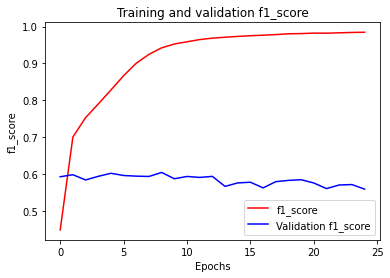

<Figure size 432x288 with 0 Axes>

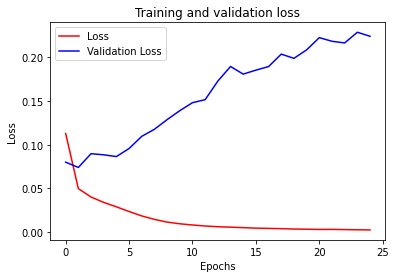

<Figure size 432x288 with 0 Axes>

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
f1=history.history['f1_score']
val_f1=history.history['val_f1_score']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(f1)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, f1, 'r')
plt.plot(epochs, val_f1, 'b')
plt.title('Training and validation f1_score')
plt.xlabel("Epochs")
plt.ylabel("f1_score")
plt.legend(["f1_score", "Validation f1_score"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

Malgré le fait que les résultats s'améliorent sur les données d'entraînement (la perte diminue et le f1 score augmente), le f1 score des données de validation atteint très vite un palier vers 60%. Il s'agit probablement d'un phénomène d'overfitting sur les données d'entraînement, lié au fait que le réseau est très basique et qu'il y a un très grand nombre de donnée donc un grand nombre de paramètre sur la matrice d'embedding. Pour résoudre ce problème, on va essayé de réduire la taille du bag of words pour diminuer le nombre de paramètres et utiliser des class_weights pour équilibrer les classes (car il y a des classes avec relativement peu de données par rapport aux autres).

## 5.3. LSTM avec taille de bag of words = 20 000 et class_weigths

Création du modèle:

In [ ]:
model = Sequential()
model.add(Embedding(20000+1, embedding_dim, input_length=max_length))
model.add(LSTM(units=64))
model.add(Dense(6, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 100)           2000100   
                                                                 
 lstm_2 (LSTM)               (None, 64)                42240     
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 2,042,730
Trainable params: 2,042,730
Non-trainable params: 0
_________________________________________________________________


Compilation du modèle en utilisant le f1_score et les classes wieghts:

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=F1Score(6, threshold = 0.5, average = 'weighted'), loss_weights = class_weights)

Entraînement du modèle en utilisant un callback pour sauvegarder les modèles pour pouvoir les réutiliser plus tard:

In [ ]:
num_epochs = 25

history = model.fit(training_padded20000, 
                      training_labels, 
                      epochs=num_epochs, 
                      validation_data=(testing_padded20000, testing_labels),
                      batch_size = 256,
                      verbose=1,
                      callbacks = ModelCheckpoint(
                          '/content/drive/MyDrive/Model/lstm_class_weights.h5', 
                          save_best_only = True, verbose=0, mode='auto', save_freq='epoch'))
  
print("Training Complete")

Epoch 1/25
624/624 [==============================] - 43s 63ms/step - loss: 0.0326 - f1_score: 0.4766 - val_loss: 0.0223 - val_f1_score: 0.6011
Epoch 2/25
624/624 [==============================] - 13s 21ms/step - loss: 0.0156 - f1_score: 0.6915 - val_loss: 0.0228 - val_f1_score: 0.6045
Epoch 3/25
624/624 [==============================] - 10s 16ms/step - loss: 0.0139 - f1_score: 0.7214 - val_loss: 0.0232 - val_f1_score: 0.6046
Epoch 4/25
624/624 [==============================] - 8s 12ms/step - loss: 0.0123 - f1_score: 0.7484 - val_loss: 0.0243 - val_f1_score: 0.6043
Epoch 5/25
624/624 [==============================] - 6s 10ms/step - loss: 0.0110 - f1_score: 0.7762 - val_loss: 0.0291 - val_f1_score: 0.6039
Epoch 6/25
624/624 [==============================] - 7s 11ms/step - loss: 0.0099 - f1_score: 0.8044 - val_loss: 0.0269 - val_f1_score: 0.6036
Epoch 7/25
624/624 [==============================] - 6s 9ms/step - loss: 0.0088 - f1_score: 0.8313 - val_loss: 0.0271 - val_f1_score: 0.60

Analyse des résultats :

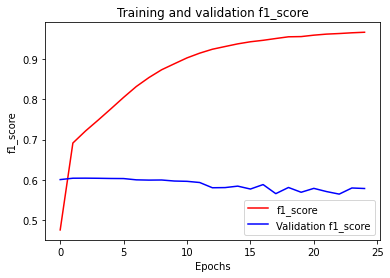

<Figure size 432x288 with 0 Axes>

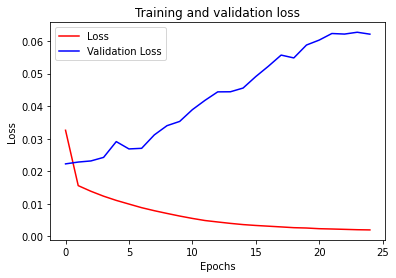

<Figure size 432x288 with 0 Axes>

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
f1=history.history['f1_score']
val_f1=history.history['val_f1_score']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(f1)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, f1, 'r')
plt.plot(epochs, val_f1, 'b')
plt.title('Training and validation f1_score')
plt.xlabel("Epochs")
plt.ylabel("f1_score")
plt.legend(["f1_score", "Validation f1_score"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

Le problème n'a pas été résolu, on a encore de l'overfitting. On va maintenant essayer d'initialiser une matrice d'embedding en utilisant la matrice GloVe.

## 5.4. LSTM with GloVe

Création du modèle:

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size+1, embedding_dim, weights=[embeddings_matrix], input_length=max_length))
model.add(LSTM(units=64))
model.add(Dense(6, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 100)           21780700  
                                                                 
 lstm_3 (LSTM)               (None, 64)                42240     
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 21,823,330
Trainable params: 21,823,330
Non-trainable params: 0
_________________________________________________________________


Compilation du modèle en utilisant le f1_score et les classes weights:

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=F1Score(6, threshold = 0.5, average = 'weighted'), loss_weights = class_weights)

Entraînement du modèle en utilisant un callback pour sauvegarder les modèles pour pouvoir les réutiliser plus tard:

In [ ]:
num_epochs = 25

history = model.fit(training_padded, 
                      training_labels, 
                      epochs=num_epochs, 
                      validation_data=(testing_padded, testing_labels),
                      batch_size = 256,
                      verbose=1,
                      callbacks = ModelCheckpoint(
                          '/content/drive/MyDrive/Model/lstm_GloVe.h5', 
                          save_best_only = True, verbose=0, mode='auto', save_freq='epoch'))

Epoch 1/25
624/624 [==============================] - 35s 53ms/step - loss: 0.0280 - f1_score: 0.4887 - val_loss: 0.0235 - val_f1_score: 0.5826
Epoch 2/25
624/624 [==============================] - 12s 20ms/step - loss: 0.0153 - f1_score: 0.6960 - val_loss: 0.0251 - val_f1_score: 0.5885
Epoch 3/25
624/624 [==============================] - 14s 22ms/step - loss: 0.0127 - f1_score: 0.7424 - val_loss: 0.0233 - val_f1_score: 0.6177
Epoch 4/25
624/624 [==============================] - 11s 18ms/step - loss: 0.0105 - f1_score: 0.7937 - val_loss: 0.0248 - val_f1_score: 0.6117
Epoch 5/25
624/624 [==============================] - 10s 15ms/step - loss: 0.0089 - f1_score: 0.8296 - val_loss: 0.0263 - val_f1_score: 0.6122
Epoch 6/25
624/624 [==============================] - 9s 14ms/step - loss: 0.0077 - f1_score: 0.8577 - val_loss: 0.0270 - val_f1_score: 0.6126
Epoch 7/25
624/624 [==============================] - 10s 16ms/step - loss: 0.0066 - f1_score: 0.8826 - val_loss: 0.0307 - val_f1_score: 

Analyse des résultats :

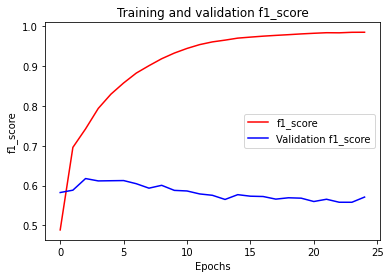

<Figure size 432x288 with 0 Axes>

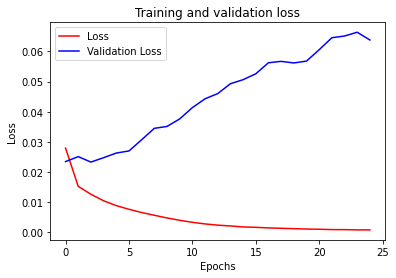

<Figure size 432x288 with 0 Axes>

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
f1=history.history['f1_score']
val_f1=history.history['val_f1_score']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(f1)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, f1, 'r')
plt.plot(epochs, val_f1, 'b')
plt.title('Training and validation f1_score')
plt.xlabel("Epochs")
plt.ylabel("f1_score")
plt.legend(["f1_score", "Validation f1_score"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

Le modèle est plus lent à atteindre le palier mais il y a toujours de l'overfitting. Pour résoudre ce problème, on va essayer de complexifier le réseau en introduisant un dropout sur le lstm.

## 5.5. LSTM with dropout

Création du modèle:

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size+1, embedding_dim, weights=[embeddings_matrix], input_length=max_length))
model.add(LSTM(units=64,  dropout = 0.5, recurrent_dropout = 0.5))
model.add(Dense(6, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 20, 100)           21780700  
                                                                 
 lstm_4 (LSTM)               (None, 64)                42240     
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
Total params: 21,823,330
Trainable params: 21,823,330
Non-trainable params: 0
_________________________________________________________________


Compilation du modèle en utilisant le f1_score et les classes weights:

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=F1Score(6, threshold = 0.5, average = 'weighted'), loss_weights = class_weights)

Entraînement du modèle en utilisant un callback pour sauvegarder les modèles pour pouvoir les réutiliser plus tard:

In [ ]:
num_epochs = 15

history = model.fit(training_padded, 
                      training_labels, 
                      epochs=num_epochs, 
                      validation_data=(testing_padded, testing_labels),
                      batch_size = 256,
                      verbose=1,
                      callbacks = ModelCheckpoint(
                          '/content/drive/MyDrive/Model/lstm_dropout.h5', 
                          save_best_only = True, verbose=0, mode='auto', save_freq='epoch'))

Epoch 1/15
624/624 [==============================] - 102s 158ms/step - loss: 0.0303 - f1_score: 0.4471 - val_loss: 0.0253 - val_f1_score: 0.5678
Epoch 2/15
624/624 [==============================] - 85s 137ms/step - loss: 0.0171 - f1_score: 0.6603 - val_loss: 0.0249 - val_f1_score: 0.5917
Epoch 3/15
624/624 [==============================] - 84s 134ms/step - loss: 0.0151 - f1_score: 0.6940 - val_loss: 0.0243 - val_f1_score: 0.6015
Epoch 4/15
624/624 [==============================] - 79s 127ms/step - loss: 0.0135 - f1_score: 0.7221 - val_loss: 0.0239 - val_f1_score: 0.6058
Epoch 5/15
624/624 [==============================] - 80s 128ms/step - loss: 0.0122 - f1_score: 0.7538 - val_loss: 0.0230 - val_f1_score: 0.6207
Epoch 6/15
624/624 [==============================] - 75s 120ms/step - loss: 0.0111 - f1_score: 0.7783 - val_loss: 0.0231 - val_f1_score: 0.6247
Epoch 7/15
624/624 [==============================] - 74s 119ms/step - loss: 0.0103 - f1_score: 0.7973 - val_loss: 0.0257 - val_f

Analyse des résultats :

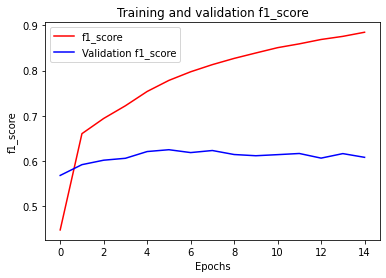

<Figure size 432x288 with 0 Axes>

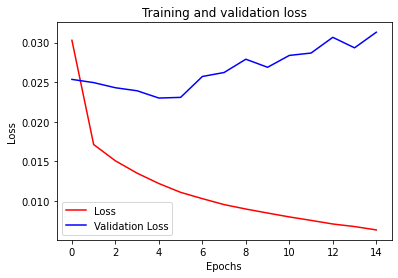

<Figure size 432x288 with 0 Axes>

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
f1=history.history['f1_score']
val_f1=history.history['val_f1_score']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(f1)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, f1, 'r')
plt.plot(epochs, val_f1, 'b')
plt.title('Training and validation f1_score')
plt.xlabel("Epochs")
plt.ylabel("f1_score")
plt.legend(["f1_score", "Validation f1_score"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

L'entrainement est beaucoup plus long et même si le résultat est un tout petit peu mieux, le problème de l'overfitting est toujours présent.

## 5.6. Bidirectional LSTM

Le dernier modèle que nous avons essayé utilise un LSTM bidirectionnel, utilisant non seulement les mots précédents mais aussi les mots suivants pour essayer de trouver le sens d'un mot.

Création du modèle:

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size+1, embedding_dim, weights=[embeddings_matrix], input_length=max_length))
model.add(Bidirectional(LSTM(units=64, dropout = 0.5, recurrent_dropout = 0.5)))
model.add(Dense(6, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 20, 100)           21780700  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense_5 (Dense)             (None, 6)                 774       
                                                                 
Total params: 21,865,954
Trainable params: 21,865,954
Non-trainable params: 0
_________________________________________________________________


Compilation du modèle en utilisant le f1_score et les classes weights:

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=F1Score(6, threshold = 0.5, average = 'weighted'), loss_weights = class_weights)

Entraînement du modèle en utilisant un callback pour sauvegarder les modèles pour pouvoir les réutiliser plus tard:

In [ ]:
num_epochs = 15

history = model.fit(training_padded, 
                      training_labels, 
                      epochs=num_epochs, 
                      validation_data=(testing_padded, testing_labels),
                      batch_size = 256,
                      verbose=1,
                      callbacks = ModelCheckpoint(
                          '/content/drive/MyDrive/Model/lstm_Bidirec.h5', 
                          save_best_only = True, verbose=0, mode='auto', save_freq='epoch'))

Epoch 1/15
624/624 [==============================] - 209s 261ms/step - loss: 0.0246 - f1_score: 0.5478 - val_loss: 0.0240 - val_f1_score: 0.5882
Epoch 2/15
624/624 [==============================] - 145s 233ms/step - loss: 0.0158 - f1_score: 0.6897 - val_loss: 0.0230 - val_f1_score: 0.6057
Epoch 3/15
624/624 [==============================] - 140s 224ms/step - loss: 0.0135 - f1_score: 0.7329 - val_loss: 0.0233 - val_f1_score: 0.6228
Epoch 4/15
624/624 [==============================] - 140s 224ms/step - loss: 0.0119 - f1_score: 0.7681 - val_loss: 0.0241 - val_f1_score: 0.6327
Epoch 5/15
624/624 [==============================] - 139s 223ms/step - loss: 0.0106 - f1_score: 0.7923 - val_loss: 0.0241 - val_f1_score: 0.6343
Epoch 6/15
624/624 [==============================] - 136s 218ms/step - loss: 0.0097 - f1_score: 0.8121 - val_loss: 0.0251 - val_f1_score: 0.6269
Epoch 7/15
624/624 [==============================] - 135s 217ms/step - loss: 0.0088 - f1_score: 0.8325 - val_loss: 0.0265 -

Analyse des résultats :

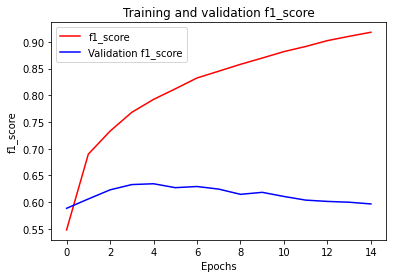

<Figure size 432x288 with 0 Axes>

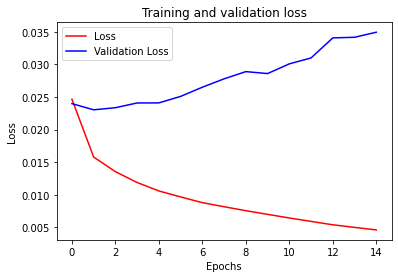

<Figure size 432x288 with 0 Axes>

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
f1=history.history['f1_score']
val_f1=history.history['val_f1_score']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(f1)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, f1, 'r')
plt.plot(epochs, val_f1, 'b')
plt.title('Training and validation f1_score')
plt.xlabel("Epochs")
plt.ylabel("f1_score")
plt.legend(["f1_score", "Validation f1_score"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

In [ ]:
testing_padded

array([[   47,   881,    14, ...,     0,     0,     0],
       [  846,   403,   196, ...,     0,     0,     0],
       [ 1050, 14200,   171, ...,    22,  1265,  2477],
       ...,
       [ 1996,     5,    32, ...,     0,     0,     0],
       [ 5956,  6657,  1119, ...,   281,   419,     0],
       [22882, 28848,  3912, ..., 15497, 22882,    91]], dtype=int32)

# **6. Pipeline**

Il faut recharger modèle que l'on juge le meilleur. Pour cela, il faut copier coller la partie création du modèle correspondant dans la cellule ci-dessous et charger les poids en indiquant le chemin faire la sauvegarde du modèle.



In [ ]:
model = Sequential()
model.add(Embedding(vocab_size+1, embedding_dim, weights=[embeddings_matrix], input_length=max_length))
model.add(Bidirectional(LSTM(units=64, dropout = 0.5, recurrent_dropout = 0.5)))
model.add(Dense(6, activation='sigmoid'))

In [ ]:
path = '/content/drive/MyDrive/Model/lstm_Bidirec.h5'
model.load_weights(path)

Ici sont définies les fonctions qui permette de faire les prédiction.

In [ ]:
def Predict(comments):
  # Permet de prédire l'appartenance aux différentes classes d'un ou plusieurs 
  # commentaires passer en argument sous forme de liste de liste
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts([*training_data['comment_text']])
  comments_sequences = tokenizer.texts_to_sequences(comments)
  comments_padded = np.array(pad_sequences(comments_sequences, maxlen=max_length, padding=trunc_type, truncating=padding_type))
  prediction = model.predict(comments_padded)  

  #Constitution du dataframe qui sera la réponse:
  for i in range(len(comments)):
    comments[i] = [comments[i]]
    comments[i].extend(prediction[i])
  df = pd.DataFrame(data=comments, columns = ['comments', 'toxic', 'severe_toxic', 'obscene',	'threat',	'insult',	'identity_hate'])

  #Explication pour comprendre le dataframe
  explaination = 'Le tableau ci-dessous regroupe les probabilités de chaque commentaire'
  explaination += ' d\'appartenir à chaque classe.\n On peut estimer qu\'un commentaire'
  explaination += ' appartient à une classe si la probabilité est sufisamment proche'
  explaination += ' de 1 (typiquement si p >0.5)'

  print(explaination)
  return df

In [ ]:
def Predict_F1score(comments, label):
  # Calcule le f1_score sur la prédiction des classes commentaires passé en 
  # argument sous forme de liste de liste par rapport aux classes auxquelles 
  # ils appartiennent réellement ('label') passé en argument sous forme de 
  # liste de liste de même taile
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts([*training_data['comment_text']])
  comments_sequences = tokenizer.texts_to_sequences(comments)
  comments_padded = np.array(pad_sequences(comments_sequences, maxlen=20, padding='post', truncating='post'))

  if(len(comments) != len(label)):
    print("Erreur, le nombre de commentaires ne correspond pas au nombre de labels")
    return 0
  prediction = model.predict(comments)
  f1_score = f1_score(prediction, label)
  mean_f1_score = f1_score(prediction, label, average = 'weighted')
  
  #Constitution du dataframe qui sera la réponse:
  for i in range(len(comments)):
    comments[i].extend(prediction[i])
    comments[i].append(mean_f1_score[i])
  df = pd.DataFrame(data=comments, columns = ['comments', 'toxic', 'severe_toxic', 'obscene',	'threat',	'insult',	'identity_hate', 'mean_f1_score'])

  return df

Puis on peut faire les prédiction ici:

In [ ]:
Predict(['you are a cunt', 'you were the chosen one', 'go fuck yourself you gay bastard', 'i will kill you'])

1/1 [==============================] - 0s 396ms/step
Le tableau ci-dessous regroupe les probabilités de chaque commentaire d'appartenir à chaque classe.
 On peut estimer qu'un commentaire appartient à une classe si la probabilité est sufisamment proche de 1 (typiquement si p >0.5)


,comments,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,you are a cunt,0.986522,0.116703,0.901595,0.009577,0.848101,0.036119
1,you were the chosen one,0.032231,0.000265,0.003486,0.000537,0.008823,0.000600
2,go fuck yourself you gay bastard,0.995546,0.509077,0.965566,0.081176,0.933688,0.375043
3,i will kill you,0.859341,0.020138,0.174588,0.042601,0.374927,0.060630


In [ ]:
# Essayer votre prédiction ici